# Testing the sensitivity of percision to threshold setting #

Using the vaidation data, test how different thresholds change model precision.

From Kraft et al 2022
```
The Validation Data was run through the classifier and precision, recall and F1-score were calculated. The threshold was varied and the value yielding the highest F1-score was chosen for a given class. The chosen thresholds were tested by running the Test Data through the classifier, and precision, recall and F1-score were calculated. Images below the thresholds were still considered when calculating performance metrics: correct images ofa class which reached the assigned threshold limit were considered as TP and incorrect images FP; correct images below the threshold limit were considered as FN and incorrect images TN.
```



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import numpy as np
import seaborn as sns
import json

# Load Classified Data #
Data is split between two files: 
- `test-xception-57-class-non-merge.csv` - contains all of the probabilities for each class for each images
- `test-xception-57-fnames-non-merge-altered.csv` - image filenames and the manually annoated class

To get at accuracy, these dataframes need to be merged

In [2]:
df = pd.read_csv("../output/20230216-soft-none_class.csv", index_col=0)
cols = df.columns
fnames = pd.read_csv("../output/20230216-soft-none_fnames.csv")
df['fname'] = fnames['fname']
df['base'] = fnames['base']
df['class_name'] = fnames['class']

Helper functions to combine the dataframes

In [3]:
def get_top_prob(row):
    return row[cols].max()

def get_top_class(row):
    ix = row[cols].values.argmax()
    return cols[ix]

In [4]:
df['top_prob'] = df.apply(get_top_prob,axis=1)
df['top_class'] = df.apply(get_top_class,axis=1)
df.head()

Akashiwo  Alexandrium_singlet  Amy_Gony_Protoc  Asterionellopsis  \
0  0.007929             0.000990     9.107120e-09      4.084455e-12   
1  0.010181             0.000396     3.152999e-11      2.543864e-14   
2  0.050487             0.044556     3.284021e-07      3.885024e-14   
3  0.026800             0.026244     1.045363e-08      2.564211e-13   
4  0.308486             0.007158     1.085467e-10      1.542535e-12   

    Boreadinium   Centric      Ceratium   Chaetoceros  Ciliates  \
0  1.131404e-07  0.000021  5.972353e-10  5.572043e-09  0.000002   
1  2.677608e-05  0.003890  3.722711e-10  5.175114e-09  0.000032   
2  4.897224e-05  0.005637  2.161419e-09  8.413080e-08  0.001784   
3  6.435865e-06  0.002715  5.346661e-09  1.677228e-08  0.008935   
4  2.352852e-06  0.015058  6.338682e-09  1.537219e-08  0.000761   

   Clusterflagellate  ...     Tintinnid      Tontonia    Torodinium  \
0       7.354164e-07  ...  9.366558e-10  2.341341e-11  1.246854e-07   
1       5.658488e-07  ...  9.224929e-10  3.383587e-09  2.772989e-07   
2       1.901874e-08  ...  1.986858e-11  2.269120e-10  1.557166e-06   
3       4.566704e-09  ...  1.014469e-09  5.518087e-09  1.275717e-06   
4       5.491783e-10  ...  5.317580e-11  3.747901e-10  3.930901e-07   

    Tropidoneis  Vicicitus                                              fname  \
0  9.370702e-10   0.990730  /home/pcdaniel/Documents/IFCB/image-extraction...   
1  1.803955e-11   0.982576  /home/pcdaniel/Documents/IFCB/image-extraction...   
2  3.000962e-11   0.876239  /home/pcdaniel/Documents/IFCB/image-extraction...   
3  1.566988e-11   0.881114  /home/pcdaniel/Documents/IFCB/image-extraction...   
4  3.923000e-12   0.663807  /home/pcdaniel/Documents/IFCB/image-extraction...   

                                 base  class_name  top_prob  top_class  
0  D20180714T050213_IFCB104_01096.png   Vicicitus  0.990730  Vicicitus  
1  D20180714T061222_IFCB104_02288.png   Vicicitus  0.982576  Vicicitus  
2  D20180714T072230_IFCB104_01085.png   Vicicitus  0.876239  Vicicitus  
3  D20180717T143205_IFCB104_00330.png   Vicicitus  0.881114  Vicicitus  
4  D20180717T160534_IFCB104_01565.png   Vicicitus  0.663807  Vicicitus  

[5 rows x 56 columns]

__Ramp threshold from (.01 to .99) and recalculate accuracy at each step__

In [5]:
class_val = df['class_name'].values
class_top = df['top_class'].values
class_prob = df['top_prob'].values
thresh = np.arange(.0,1,0.01)
class_acc_all = np.zeros(len(thresh))
class_f = np.zeros(len(thresh))

In [6]:
for i, t in enumerate(thresh):
    new_class = np.copy(class_top)
    ixs = np.where(class_prob < t)
    new_class[ixs] = 'Unknown'
    class_acc_all[i] = sklearn.metrics.accuracy_score(class_val, new_class,normalize=True)
    class_f[i] = sklearn.metrics.f1_score(class_val, new_class, average="weighted")

__Plot Results__

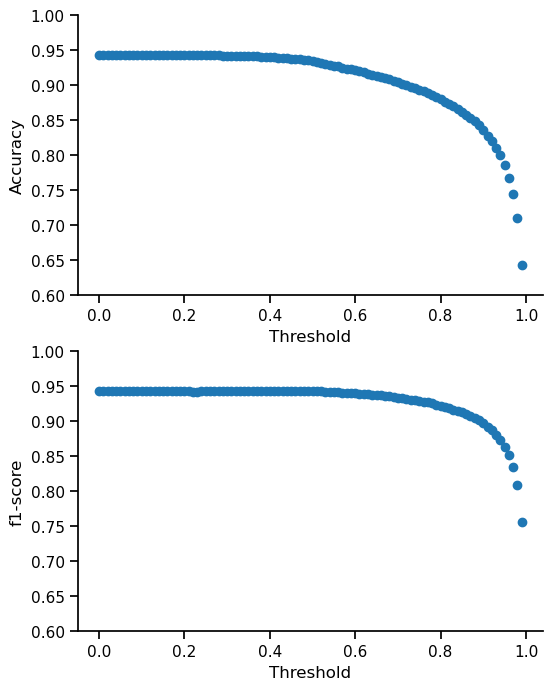

In [7]:
sns.set_context("notebook")

fig, (ax, ax2) = plt.subplots(2)
fig.set_size_inches(6,8)
ax.scatter(thresh, class_acc_all)
ax.set_xlabel("Threshold")
ax.set_ylabel("Accuracy")
ax.set_ylim(.6,1)

ax2.scatter(thresh, class_f)
ax2.set_xlabel("Threshold")
ax2.set_ylabel("f1-score")
ax2.set_ylim(.6,1)
sns.despine()
# plt.savefig("../notebooks/figures/51_class_threshold_sensitivity_all_soft_none.png", dpi=300, bbox_inches='tight')

## Calculate accuracy for each class ##

Store data in `class_acc` which should (57 x 100)

In [8]:

thresh = np.arange(.0,1,0.01)
class_acc = np.zeros((cols.shape[0],len(thresh))) # 57 x 100

for j, c in enumerate(cols):
    class_df = df.query("class_name == @c")
    class_val = class_df['class_name'].values
    class_top = class_df['top_class'].values
    class_prob = class_df['top_prob'].values
    for i, t in enumerate(thresh):
        new_class = np.copy(class_top)
        ixs = np.where(class_prob < t)
        new_class[ixs] = 'Unknown'
        class_acc[j,i] = sklearn.metrics.accuracy_score(class_val, new_class,normalize=True)

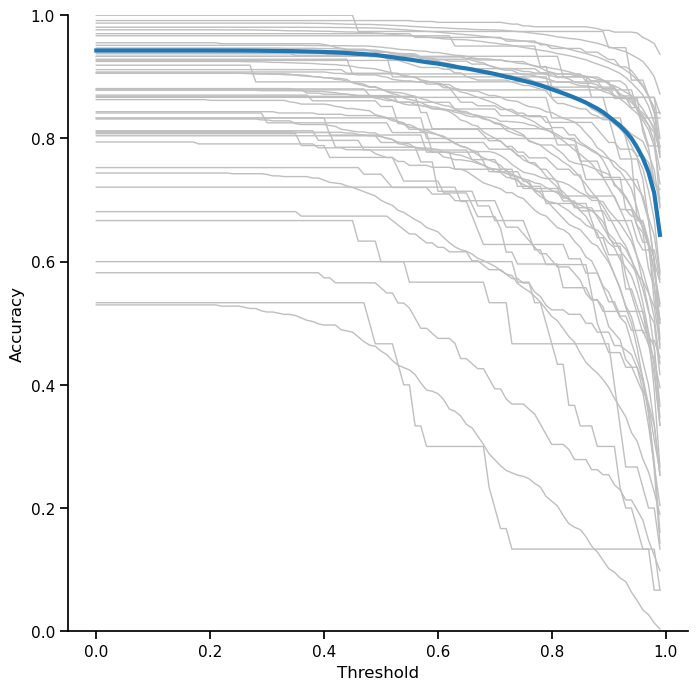

In [9]:
sns.set_context("notebook")

fig, ax = plt.subplots()
fig.set_size_inches(8,8)
for k in range(cols.shape[0]):
    ax.plot(thresh, class_acc[k,:],color='.75',marker='None',lw=1)

ax.plot(thresh, class_acc_all, marker='None',lw=3)
ax.set_xlabel("Threshold")
ax.set_ylabel("Accuracy")
ax.set_ylim(0,1)

sns.despine()
# plt.savefig("../notebooks/figures/threshold_sensitivity_acc_byclass_soft_none.png", dpi=300, bbox_inches='tight')

In [10]:
thresh = np.arange(.0,1,0.01)
class_fscore = np.zeros((cols.shape[0],len(thresh))) # 57 x 100

for j, c in enumerate(cols):
    class_df = df.query("class_name == @c")
    class_val = class_df['class_name'].values
    class_top = class_df['top_class'].values
    class_prob = class_df['top_prob'].values
    for i, t in enumerate(thresh):
        new_class = np.copy(class_top)
        ixs = np.where(class_prob < t)
        new_class[ixs] = 'Unknown'
        class_fscore[j,i] = sklearn.metrics.f1_score(class_val, new_class, average="weighted")

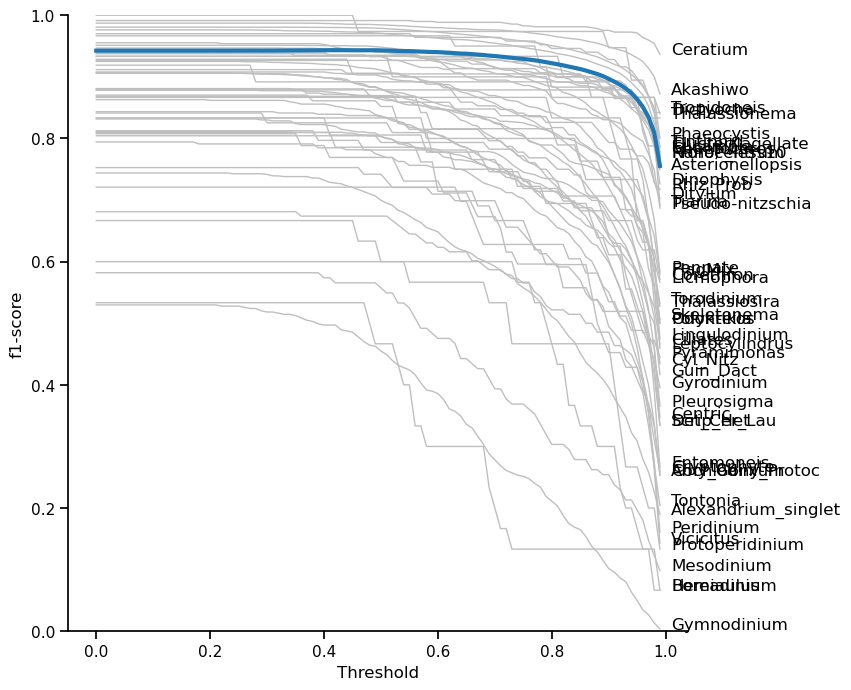

In [11]:
sns.set_context("notebook")

fig, ax = plt.subplots()
fig.set_size_inches(8,8)
for k in range(cols.shape[0]):
    ax.plot(thresh, class_acc[k,:],color='.75',marker='None',lw=1)
    ax.text(x=1.01, y=class_acc[k,-1], s=cols[k])

ax.plot(thresh, class_f, marker='None',lw=3)
ax.set_xlabel("Threshold")
ax.set_ylabel("f1-score")
ax.set_ylim(0,1)

sns.despine()
# plt.savefig("../notebooks/figures/threshold_sensitivity_f1_byclass_soft_none.png", dpi=300, bbox_inches='tight')

In [12]:
np.diff(class_acc,axis=1)

array([[ 0.        ,  0.        ,  0.        , ..., -0.0110453 ,
        -0.01376661, -0.02785337],
       [ 0.        ,  0.        ,  0.        , ..., -0.0209546 ,
        -0.03259604, -0.03608847],
       [ 0.        ,  0.        ,  0.        , ..., -0.02173913,
        -0.03623188, -0.07971014],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.0326087 ,
        -0.04347826, -0.05434783],
       [ 0.        ,  0.        ,  0.        , ..., -0.02631579,
        -0.02631579,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.04761905,
        -0.0952381 , -0.11904762]])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

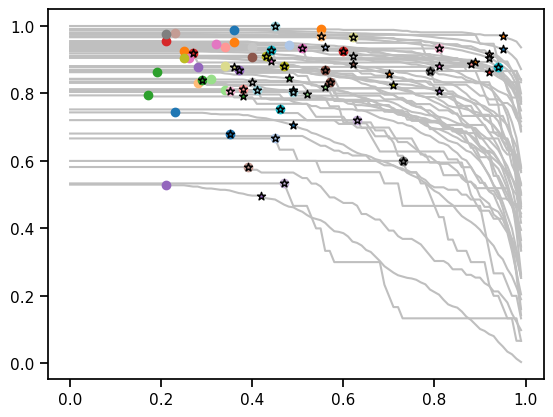

In [37]:
fig,ax = plt.subplots()
class_thresh = []

n = len(cols)
color = iter(plt.cm.tab20(np.linspace(0, 1, n)))

for i in range(len(cols)):
    c = next(color);
    t = class_acc[i,:]
    t_dif = np.diff(t)
    ix = np.where(t_dif < 0)[0][0]
    ax.plot(thresh, t,c='.75');
    ax.scatter(thresh[ix], t[ix], c=c,zorder=10);
    
    ix = np.where(t_dif < -.005)[0][0]
    ax.scatter(thresh[ix], t[ix],marker='*',c=c,edgecolors='k',zorder=100);
    
    class_thresh.append(round(thresh[ix],5))

In [38]:
keys = cols
values = class_thresh
dictionary = dict(zip(keys, values))
with open("../output/class_threshold.json", "w") as outfile:
    json.dump(dictionary, outfile)

In [19]:
t_dif

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.02380952,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.02380952,  0.        ,  0.        , -0.04761905,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.02380952,  0.        ,  0.        , -0.02